In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torchvision
from timm import create_model
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import torch.nn as nn

In [5]:
# Define the transform
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Load the pretrained model
classificator = create_model('vgg11_bn.tv_in1k', pretrained=True).eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/532M [00:00<?, ?B/s]

In [7]:
# Define the class index for chicken in ImageNet
chicken_imagenet_class_idx = 8

tensor(0.8525)


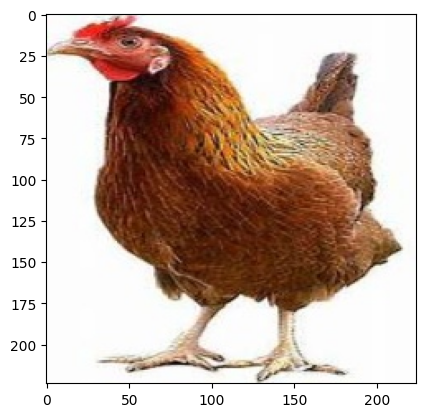

In [8]:
# Load and preprocess the image
SOURCE_IMAGE_PATH = f"/content/drive/MyDrive/DATA1/2.jpeg"
image = Image.open(SOURCE_IMAGE_PATH)

with torch.no_grad():
    logits = classificator(transform(image).unsqueeze(0)).squeeze(0)
    probs = torch.softmax(logits, 0)
    print(probs[chicken_imagenet_class_idx])

plt.imshow(image)
plt.show()

In [9]:
# Get all image paths
paths = [path for path in Path('/content/drive/MyDrive/DATA1/gallina1').rglob('*.jpeg')]

In [27]:
def calculate_weight_importance(conv_weights):
    # Calculate the mean absolute value of the weights
    mean_abs_value = torch.mean(torch.abs(conv_weights))
    return mean_abs_value

In [28]:
def prune_least_important(weight_importances, pruning_rate):
    # Sort the weights by importance and keep only the most important ones
    sorted_idxs = torch.argsort(weight_importances)
    num_to_keep = int((1 - pruning_rate) * len(sorted_idxs))
    pruned_idxs = sorted_idxs[-num_to_keep:]
    return pruned_idxs

In [29]:
def adjust_bias(conv_bias, bn_running_mean, bn_weight, pruned_weights):
    # Calculate the adjusted bias
    adjusted_bias = conv_bias - (bn_running_mean * bn_weight[:, None, None, None])

    # Adjust the bias based on pruned weights
    if pruned_weights is not None:
        adjusted_bias *= pruned_weights
    return adjusted_bias

In [30]:
def fuse_bn_optimized(module, pruning_rate=0.1):
    module_output = module
    if isinstance(module, nn.Sequential):
        for idx in range(len(module) - 1):
            if isinstance(module[idx], nn.Conv2d) and isinstance(module[idx + 1], nn.BatchNorm2d):
                conv = module[idx]
                bn = module[idx + 1]

                # Calculate the importance score for each weight
                weight_importance = calculate_weight_importance(conv.weight)

                # Prune the least important weights
                pruned_weights = prune_least_important(weight_importance, pruning_rate)
                conv.weight.data = conv.weight * pruned_weights

                # Adjust bias based on pruned weights
                if conv.bias is not None:
                    conv.bias.data = adjust_bias(conv.bias, bn.running_mean, bn.weight, pruned_weights)
            module[idx + 1] = nn.Identity()
        for name, child in module.named_children():
            module_output.add_module(name, fuse_bn(child))
    del module
    return module_output

In [31]:
# Fuse batch normalization layers
classificator_without_bn = create_model('vgg11_bn.tv_in1k', pretrained=True).eval()
classificator_without_bn = fuse_bn_optimized(classificator_without_bn)
layers = [layer for layer in list(classificator_without_bn.features) if not isinstance(layer, nn.Identity)]
classificator_without_bn.features = nn.Sequential(*layers)

  0%|          | 0/260 [00:00<?, ?it/s]

0.5249027195983462 0.5940357744693756


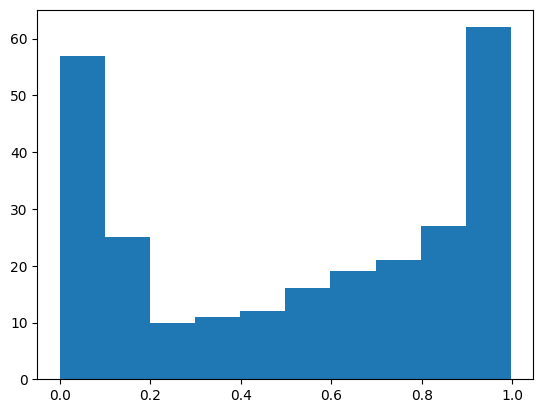

In [32]:
# Calculate distribution probabilities
dist_probs = []
for path in tqdm(paths):
    image = Image.open(path).convert('RGB')
    tensor = transform(image).unsqueeze(0)
    with torch.inference_mode():
        logits = classificator_without_bn(tensor).squeeze(0)
        probs = torch.softmax(logits, 0)
        chicken_prob = probs[chicken_imagenet_class_idx]
        dist_probs.append(chicken_prob.item())

print(np.mean(dist_probs), np.median(dist_probs))
plt.hist(dist_probs)
plt.show()

In [46]:
# Pruning based on a combination of L1 and L2 norms
weights = classificator.head.fc.weight
abs_weights = weights.abs()
l1_norm = abs_weights.sum(dim=0)
l2_norm = (weights ** 2).sum(dim=0).sqrt()
combined_statistics = l1_norm + l2_norm  # Combine L1 and L2 norms for pruning
pruned_idxs = combined_statistics.sort()[1][:int(0.95 * len(combined_statistics))]

In [47]:
# Create new layers with pruned connections
fc = nn.Linear(in_features=len(pruned_idxs), out_features=1000, bias=True)
fc.weight.data = classificator.head.fc.weight[:, pruned_idxs]

conv = nn.Conv2d(4096, len(pruned_idxs), kernel_size=(1, 1), stride=(1, 1))
conv.weight.data = classificator.pre_logits.fc2.weight[pruned_idxs, :, :, :]
conv.bias.data = classificator.pre_logits.fc2.bias[pruned_idxs]

In [48]:
# Create pruned model
pruned_classificator = create_model('vgg11_bn.tv_in1k', pretrained=True).eval()
pruned_classificator.head.fc = fc
pruned_classificator.pre_logits.fc2 = conv
pruned_classificator = pruned_classificator.eval()

  0%|          | 0/260 [00:00<?, ?it/s]

0.5391663391283985 0.6394334733486176


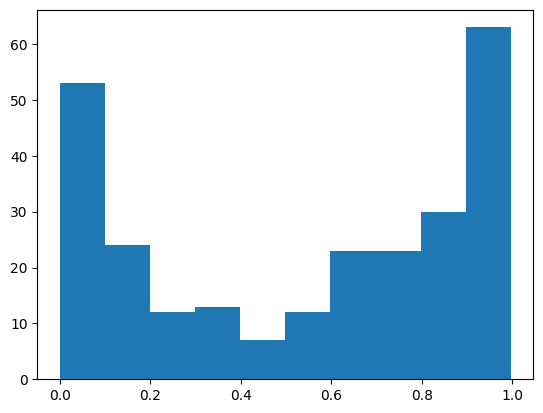

In [49]:
# Calculate distribution probabilities for pruned model
dist_probs = []
for path in tqdm(paths):
    image = Image.open(path).convert('RGB')
    tensor = transform(image).unsqueeze(0)
    with torch.inference_mode():
        logits = pruned_classificator(tensor).squeeze(0)
        probs = torch.softmax(logits, 0)
        chicken_prob = probs[chicken_imagenet_class_idx]
        dist_probs.append(chicken_prob.item())

print(np.mean(dist_probs), np.median(dist_probs))
plt.hist(dist_probs)
plt.show()